## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Preparation](#data)
* [Data Exploration](#analysis)
* [Methodology](#methodology)

* [Results and Discussion](#results)
* [Conclusion](#conclusion)





## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal location for a restaurant. Specifically, this report is targeted at stakeholders interested in opening an **burger joint** in **New York City**, USA, within a walking distance to popular sightseeing attractions in the borough of Manhattan. We will find and evaluate the most and least favorable location for the burger restaurant (based on our approach) for each sightseeing attraction.


## Data Preparation <a name="data"></a>

Based on the definition of our business problem, factors that will influence our decision are:
* number of existing burger restaurants near the sightseeing attraction
* rating of existing burger restaurants near the sightseeing attraction
* distance of the potential location of our new restaurant from the sightseeing attraction
* **weighted sum of distances** from our new restaurant to the existing restaurants 

We will define a list of popular sightseeing attractions ("attractions" hereafter) manually and use the **Nominatim geocoder** afterwards to obtain the latitude/longitude information for these. Then, we will get and cleanse the data we need for each attraction as follows:

* We will retrieve restaurants nearby each attraction using a **Foursquare API venue explore call with the search word "burger"**.
* We will filter the outputted restaurants further by the category name "burger joint"

At this step, we will limit our analysis to the top 6 attractions with the most burger joints nearby. This has mainly practical reasons since there is a limit on the number of premium calls authorized per day for the Sandbox account for the Foursquare API.

* For the reduced number of sightseeing locations and venues we use the **Foursquare API** again to get **the rating information for each venue**



### 1. Attractions or  "neighborhoods"

Let us first import the required python packages:

In [182]:
#!pip install folium
#!pip install geocoder
#!pip install pyproj
!pip install geopy

In [183]:
from pandas import json_normalize # tranform JSON file into a pandas dataframe

In [184]:

import geocoder
import numpy as np

import pandas as pd

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors



import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
#print('Matplotlib version: ', mpl.__version__) # >= 2.0.0
%matplotlib inline


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Now, let us define popular attractions in New York (inspired by https://lovingnewyork.de/sehenswuerdigkeiten/unsere-top-10-der-sehenswuerdigkeiten-in-new-york/).

Based on this first manual inspection, we find 17 attractions that are of particular interest. 

Note: We provide a more exact address for "Central Park" because the Central Park spans a larger area and we are more interested in venues near the Southern border of it.

In [185]:
#We first define a list of sightseeing attraction
touristy_locations=['Empire State Building, New York, NY',
                    'Top of the Rock, New York, NY',
                    'High Line Park, New York, NY',
                    'Times Square, New York, NY',
                    
                    'Brooklyn Bridge Park, New York, NY',
                    'Staten Island Ferry, New York, NY',
                    '117 W 58th St, New York, NY 10019', #for south central park
                    
                    'Wall Street, New York, NY',
                    'Grand Central Terminal, New York, NY',
                    'The Vessel, New York, NY',
                    'Flatiron, New York, NY',
                    
                    'One World Trade Center, New York, NY',
                    'One World Observatory, New York, NY',
                  
                    'DUMBO, New York, NY',
                    'The Edge, New York, NY',
                   
                   'Bryant Park, New York, NY',
                    'New York Public Library, New York, NY'
                   ]


print(len(touristy_locations))

17


In [186]:
# Then we define a new Dataframe of sightseeing locations, hereafter "neighborhoods"
columns = ['neighborhood']
df_sights = pd.DataFrame(touristy_locations,columns=columns,index=np.arange(len(touristy_locations)))

df_sights

,neighborhood
0,"Empire State Building, New York, NY"
1,"Top of the Rock, New York, NY"
2,"High Line Park, New York, NY"
3,"Times Square, New York, NY"
4,"Brooklyn Bridge Park, New York, NY"
5,"Staten Island Ferry, New York, NY"
6,"117 W 58th St, New York, NY 10019"
7,"Wall Street, New York, NY"
8,"Grand Central Terminal, New York, NY"
9,"The Vessel, New York, NY"


We now define the functions that help us in mapping an address to the corresponding latitude & longitude degrees (spatial coordinates, "coordinates" hereafter) and vice versa with the help of the Nominatim geocoder API:

In [187]:
                 
     

def get_latlng_from_address(address):
        #address =row['neighborhood']
        geolocator = Nominatim(user_agent="foursquare_agent")
        
        try:
            location = geolocator.geocode(address)
            return [location.latitude,location.longitude]

        except:
             return None

            
def get_address_from_latlng(latlng):      
        #latlng =row['neigh.latlng']
        geolocator = Nominatim(user_agent="foursquare_agent")
        
        try:
            location = geolocator.reverse(latlng)
            return location.address
            
        except:
            
            return None





Now, we are able to add the column with the coordinates to the dataframe (applying the above function as lambda function):

In [188]:
            
            
df_sights['neigh.latlng']= df_sights.apply(lambda x: get_latlng_from_address(x['neighborhood']), axis=1)

df_sights['neighborhood'] =[neigh.split(",") [0] for neigh in df_sights['neighborhood']]
df_sights


,neighborhood,neigh.latlng
0,Empire State Building,"[40.748428399999995, -73.98565461987332]"
1,Top of the Rock,"[40.7590344, -73.9793952]"
2,High Line Park,"[40.745118, -74.0066972]"
3,Times Square,"[40.757280550000004, -73.98585503545917]"
4,Brooklyn Bridge Park,"[40.69753125, -73.998754523565]"
5,Staten Island Ferry,"[40.7011583, -74.0128326]"
6,117 W 58th St,"[40.765458699999996, -73.977171453739]"
7,Wall Street,"[40.704756, -74.006889]"
8,Grand Central Terminal,"[40.7528064, -73.9771792]"
9,The Vessel,"[40.753788400000005, -74.00215367097266]"


Let us cleanse the data further. As we notice that the coordinates of One World Trade Center and Observatory are actually very close to each other we will consider this pair as one attraction i.e. neighborhood as we move on with the analysis. The same applies to the coordinates of Bryant Park and New York Public Library, which we will also treat as one (paired) attraction. 

In [189]:
df_sights.loc[6,'neighborhood']='Central Park, New York, NY'

latmean=(df_sights.loc[11,'neigh.latlng'][0]+ df_sights.loc[12,'neigh.latlng'][0])/2
lngmean=(df_sights.loc[11,'neigh.latlng'][1]+ df_sights.loc[12,'neigh.latlng'][1])/2

latmean1=(df_sights.loc[15,'neigh.latlng'][0]+ df_sights.loc[16,'neigh.latlng'][0])/2
lngmean1=(df_sights.loc[15,'neigh.latlng'][1]+ df_sights.loc[16,'neigh.latlng'][1])/2



df_sights.loc[11,'neigh.latlng'][0]=latmean
df_sights.loc[11,'neigh.latlng'][1]=lngmean
df_sights.loc[11,'neighborhood']='One World Trade Center & Observatory, New York, NY'


df_sights.loc[15,'neigh.latlng'][0]=latmean1
df_sights.loc[15,'neigh.latlng'][1]=lngmean1
df_sights.loc[15,'neighborhood']='Bryant Park & Public Library, New York, NY'


df_sights.drop(labels=[12], axis=0,inplace=True)

df_sights.drop(labels=[16], axis=0,inplace=True)

df_sights=df_sights.reset_index(drop=True)


# Get an exact address name for each sightseeing location with the Nominatim geocoder
df_sights['address']=df_sights.apply(lambda x: get_address_from_latlng(x['neigh.latlng']), axis=1)




We also define a label column for each attraction/neighborhood, which will come in handy later.

In [190]:
# de

df_sights['neigh.id']=df_sights.index
df_sights

,neighborhood,neigh.latlng,address,neigh.id
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1
2,High Line Park,"[40.745118, -74.0066972]","High Line Park, High Line, Chelsea, Manhattan,...",2
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3
4,Brooklyn Bridge Park,"[40.69753125, -73.998754523565]","Pier 3, South Battery, Manhattan Community Boa...",4
5,Staten Island Ferry,"[40.7011583, -74.0128326]","Staten Island ferry, 4, South Street, Financia...",5
6,"Central Park, New York, NY","[40.765458699999996, -73.977171453739]","117, West 58th Street, Columbus Circle, Manhat...",6
7,Wall Street,"[40.704756, -74.006889]","111 Wall Street, 111, Wall Street, Financial D...",7
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8
9,The Vessel,"[40.753788400000005, -74.00215367097266]","The Vessel, Hudson Boulevard East, Hudson Yard...",9


Now let us create a map of New York with Folium and mark the coordinates per attractions in the map, using different colors:

In [334]:
# create map of New York using mean latitude and mean longitude values


# calculate mean lat/long in data set by loop

latitude_mean=0
longitude_mean=0


for index, row in df_sights.iterrows():    
    latlng=row['neigh.latlng']
    latitude_mean =latitude_mean+latlng[0]
    longitude_mean =longitude_mean+latlng[1]

latitude_mean=latitude_mean/df_sights.shape[0]
longitude_mean=longitude_mean/df_sights.shape[0]

print(latitude_mean,longitude_mean)

# create map
map_newyork = folium.Map(location=[latitude_mean, longitude_mean], zoom_start=13)



40.74105011333334 -73.9902919971179


In [335]:

import matplotlib.cm as cm


nb_neigh=df_sights.shape[0]

x = np.arange(nb_neigh)
ys = [i + x + (i*x)**2 for i in range(nb_neigh)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for latlng, neighborhood,cluster in zip(df_sights['neigh.latlng'], df_sights['neighborhood'],df_sights['neigh.id']):

    label = '{}, cluster {}'.format(neighborhood,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        latlng,
        radius=5,
        popup=label,
        color='black',#rainbow[cluster], 
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    

map_newyork


In [336]:
map_newyork.save("mapsights.html")

To immediately get the distance in meters between two attractions (defined by their coordinates) we can either leverage the Geod class from the pyproj package or use the haversine formula to compute the distance ourself. To this end, we define the following functions:

In [193]:

def get_distance_GEOD(latlng1, latlng2):
    '''
    Returns Distance in meters from GEOD
     '''
    
    
    try:
        Lat1=latlng1[0]
        Lon1=latlng1[1]
        Lat2=latlng2[0]
        Lon2=latlng2[1]
    
        G = pyproj.Geod(ellps='WGS84')
        # Returns tuple with Forward azimuth(s), Back azimuth(s),Distance in meters
        dist=G.inv(Lon1, Lat1, Lon2, Lat2)[2]
        return dist
    
    except:
        return None



def get_distance_Haversine(latlng1, latlng2):
    
    '''
    Distance in meters between two points given by lat,lng with the help of Haversine formula
    ''' 
    R = 6371 # Radius of earth in kilometers.
    lat1 = radians(latlng1[0])  
    lon1 = radians(latlng1[1])
    lat2 = radians(latlng2[0])
    lon2 = radians(latlng2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c #km
    
    return distance*1000



However, since we will define our problem as an optimization in the Cartesian 2D coordinate system later, we also need to create some functions to switch back and forward between the  WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters). 

After having found the optimal location for our new burger restaurant in the 2D coordinate system close to each sightseeing attraction with our Optimizer we will need to project these back to latitude/longitude degrees in order to visualize the results on the Folium map.

In [194]:
import pyproj
from math import sin, cos, sqrt, atan2, radians


def LatLon_To_XY(latlng):
  
    try:
        Lat=latlng[0]
        Lon=latlng[1]
        P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)
        return list(P(Lat,Lon)) #convert tuple to list  
    except:
        None

def XY_To_LatLon(xy):
   
    try:
        x=xy[0]
        y=xy[1]
        P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)
        
        return list(P(x,y,inverse=True))   #convert tuple to list   

    except:
        return None
    



Let us now add the xy coordinates for each attraction to our dataframe:

In [195]:
df_sights['neigh.xy']=df_sights.apply(lambda x: LatLon_To_XY(x['neigh.latlng']), axis=1)
df_sights

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]"
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]"
2,High Line Park,"[40.745118, -74.0066972]","High Line Park, High Line, Chelsea, Manhattan,...",2,"[2121015.2382253, -10790093.130118066]"
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]"
4,Brooklyn Bridge Park,"[40.69753125, -73.998754523565]","Pier 3, South Battery, Manhattan Community Boa...",4,"[2122510.0632854747, -10789151.932822015]"
5,Staten Island Ferry,"[40.7011583, -74.0128326]","Staten Island ferry, 4, South Street, Financia...",5,"[2121008.6856371397, -10788529.10136225]"
6,"Central Park, New York, NY","[40.765458699999996, -73.977171453739]","117, West 58th Street, Columbus Circle, Manhat...",6,"[2123764.4957960993, -10792196.209785866]"
7,Wall Street,"[40.704756, -74.006889]","111 Wall Street, 111, Wall Street, Financial D...",7,"[2121569.631100337, -10788937.669686109]"
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]"
9,The Vessel,"[40.753788400000005, -74.00215367097266]","The Vessel, Hudson Boulevard East, Hudson Yard...",9,"[2121359.470262422, -10790573.855653124]"


This now brings us to the question: How should we define the search radius for other burger restaurants around each attraction when using Foursquare? 

It would be interesting to find the max radius such that each attraction defines a separate search area, i.e. there is no overlap.

To this end, let us determine the minimum distances between the attractions from our list:

In [196]:

# We use the dist method of the scipy distance class to create a distance matrix for our sightseeing locations.

# Fortunately we are able to specify the way the distance metric should be calculated (euclidean, etc.)
#and can even hand over our own Haversine distance function (using lat/lon values directly) to the dist method

from scipy.spatial import distance



def get_distance_df(m1_latlng, names):
    
    distance_matrix= distance.cdist(m1_latlng,m1_latlng,get_distance_Haversine)
    df=pd.DataFrame(distance_matrix, index=names, columns=names)
    return df



def min_interdist(m1_latlng, names):

    mindist=10000000 #meter
    
    neigh_inter_distance_df=get_distance_df(m1_latlng,names)

    r=neigh_inter_distance_df.shape[0]
    c=neigh_inter_distance_df.shape[1]

    for i in list(range(0, r)):
        for j in list(range(0, c)):
            if i!=j:
                if neigh_inter_distance_df.iloc[i,j] <mindist:
                    mindist=neigh_inter_distance_df.iloc[i,j]

            
    return  mindist




In [197]:
m1_latlng=np.array(list(df_sights['neigh.latlng']))
rownames=df_sights['neighborhood'].tolist()

m1_latlng

array([[ 40.7484284 , -73.98565462],
       [ 40.7590344 , -73.9793952 ],
       [ 40.745118  , -74.0066972 ],
       [ 40.75728055, -73.98585504],
       [ 40.69753125, -73.99875452],
       [ 40.7011583 , -74.0128326 ],
       [ 40.7654587 , -73.97717145],
       [ 40.704756  , -74.006889  ],
       [ 40.7528064 , -73.9771792 ],
       [ 40.7537884 , -74.00215367],
       [ 40.7410592 , -73.98964162],
       [ 40.71301212, -74.01312185],
       [ 40.7029052 , -73.9901167 ],
       [ 40.8198671 , -73.9460727 ],
       [ 40.75354768, -73.98284458]])

In [198]:
df_neigh_dist=get_distance_df(m1_latlng,  rownames)
df_neigh_dist


,Empire State Building,Top of the Rock,High Line Park,Times Square,Brooklyn Bridge Park,Staten Island Ferry,"Central Park, New York, NY",Wall Street,Grand Central Terminal,The Vessel,Flatiron,"One World Trade Center & Observatory, New York, NY",DUMBO,The Edge,"Bryant Park & Public Library, New York, NY"
Empire State Building,0.000000,1291.827092,1810.473244,984.458927,5766.168603,5733.491316,2024.001294,5175.324935,864.115993,1512.218201,885.585385,4567.858893,5075.895104,8614.354055,616.491125
Top of the Rock,1291.827092,0.000000,2771.917071,577.987499,7030.710077,7025.272772,738.493143,6464.816592,717.235124,2003.718959,2177.154379,5853.473678,6306.326428,7322.942319,675.744221
High Line Park,1810.473244,2771.917071,0.000000,2216.158217,5333.573825,4915.364463,3361.651236,4488.078733,2629.418742,1037.297429,1506.078800,3610.824207,4897.398274,9753.927770,2217.182106
Times Square,984.458927,577.987499,2216.158217,0.000000,6732.152288,6641.651101,1166.976785,6103.461637,884.047512,1426.700442,1831.718940,5432.154033,6056.917444,7723.288763,486.402636
Brooklyn Bridge Park,5766.168603,7030.710077,5333.573825,6732.152288,0.000000,1253.459440,7769.039649,1056.222545,6409.585752,6262.064284,4900.639763,2104.736023,941.970156,14308.519754,6371.398511
Staten Island Ferry,5733.491316,7025.272772,4915.364463,6641.651101,1253.459440,0.000000,7755.598750,641.143662,6481.394446,5920.980614,4848.160304,1318.310679,1924.734543,14347.504338,6349.901881
"Central Park, New York, NY",2024.001294,738.493143,3361.651236,1166.976785,7769.039649,7755.598750,0.000000,7199.284228,1406.871722,2472.112455,2909.340321,6571.437079,7040.632962,6592.090135,1408.001800
Wall Street,5175.324935,6464.816592,4488.078733,6103.461637,1056.222545,641.143662,7199.284228,0.000000,5900.390758,5466.735619,4290.427126,1057.734701,1428.734889,13786.571791,5791.355210
Grand Central Terminal,864.115993,717.235124,2629.418742,884.047512,6409.585752,6481.394446,1406.871722,5900.390758,0.000000,2106.511725,1675.834087,5362.060906,5654.842302,7903.330459,484.280264
The Vessel,1512.218201,2003.718959,1037.297429,1426.700442,6262.064284,5920.980614,2472.112455,5466.735619,2106.511725,0.000000,1764.762118,4627.339607,5748.150149,8733.841504,1626.677657


In [199]:

mindist=min_interdist(m1_latlng, rownames)

print('The smallest distance between any of the defined sightseeing attractions is {}'. format(mindist))

The smallest distance between any of the defined sightseeing attractions is 484.2802641401813


###  2. Foursquare API

#### 2.1.  Explore burger joints near attraction with Foursquare
Now that we have defined our attractions properly, let us use Foursquare API to get burger restaurants close to each of our identified attractions.


In the following cell, we define the Foursquare API credentials.

In [200]:
CLIENT_ID = 'NROBF02A4FI4HHG101DGTBBKK5LGWK2BZWBNZMBXGLIGCH0W' # your Foursquare ID
CLIENT_SECRET = '0RKFO0HXIHCQENFQASBHKV5ZCF2TKXWW1V53GDFEMQ2A2KF5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Let's define the functions to extract the data from the API:

In [201]:
# help function to get primary category name from returned category list

def get_category_name(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    
    else:
        
          for cat in categories_list:
            if cat['primary']==True:
                return cat['name']
            else:
                return None
        #return categories_list[0]['name']
    
    
# help function to get primary category id from returned category list

def get_category_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        
        for cat in categories_list:
            if cat['primary']==True:
                return cat['id']
            else:
                return None
                #return categories_list[0]['id']
                
                
# help function to format venue address nicely

def get_address(row):
   
    adress_list = row['venue.location.formattedAddress']
        
    if len(adress_list) == 0:
        return None
    else:
        return adress_list[0] + ',' + adress_list[1]
    
def get_venuelatlng(lat,lng):
        return [lat,lng]


In [202]:
#main function to explore venues by search word "burger" in radius around sightseeing location
# returns Dataframe!

def search_nearby_burgerplaces(neigh, neighid,latlng, client_id, client_secret,radius,limit,query):
    
    '''
    function to get nearby restaurants search item burger
    '''
    
    lat=latlng[0]
    lng=latlng[1]
    
    version= '20180605'
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query
        )
            
    
    
    
    try:


        results0=requests.get(url).json()
        results =results0['response']['groups'][0]['items']
        
        #suggestedradius=results0['response']['suggestedRadius']
      
        neigh_restaurants_df = json_normalize(results) # json normalize tips

        
        filtered_columns = ['venue.name','venue.id','venue.location.lat','venue.location.lng','venue.location.distance',
                            'venue.location.formattedAddress','venue.categories']
     
        
        neigh_restaurants_df = neigh_restaurants_df.loc[:, filtered_columns]
   
        neigh_restaurants_df['venue.category_name'] =neigh_restaurants_df.apply(get_category_name, axis=1)
        neigh_restaurants_df['venue.category_id'] = neigh_restaurants_df.apply(get_category_id, axis=1)
        
       
        neigh_restaurants_df['venue.address'] = neigh_restaurants_df.apply(get_address, axis=1)
        neigh_restaurants_df['venue.latlng']=neigh_restaurants_df.apply(lambda x :get_venuelatlng(x['venue.location.lat'],x['venue.location.lng']), axis=1)
        

        #neigh_restaurants_df['radius_from_neigh']=suggestedradius
        
        
        
        # Additional columns
        
     

        neigh_restaurants_df['neighborhood']=neigh
        neigh_restaurants_df['neigh.id']=neighid
    
        #clean up
        
        neigh_restaurants_df.drop(columns=['venue.categories','venue.location.formattedAddress','venue.location.lat','venue.location.lng'] , axis=1,inplace=True)
     
        
        neigh_restaurants_df.rename(columns={'venue.location.distance':'venue.distance'}, inplace=True)
        
        
        
        
        return neigh_restaurants_df
        

        
    except:
         return 'error'
        
        


Let's call this function for each attraction with a max radius of 400 meters around each attraction and max 50 items returned. Since the function directly yields a dataframe we create a loop to attach each new dataframe to the old one.

In [203]:
radius= 400#round(mindist)
limit=50
query='burger'


columns=['venue.name', 'venue.id', 'venue.distance', 'venue.category_name',
       'venue.category_id', 'venue.address', 'venue.latlng', 'neighborhood',
       'neigh.id']


all_burgerjoints = pd.DataFrame(columns=columns)

#latlong=[40.748428399999995, -73.98565461987332]

for neighid,latlng, neigh in zip(df_sights['neigh.id'],df_sights['neigh.latlng'], df_sights['neighborhood']):
    df=search_nearby_burgerplaces(neigh,neighid,latlng, CLIENT_ID, CLIENT_SECRET,radius,limit,query)
    all_burgerjoints=all_burgerjoints.append(df,ignore_index=True)
    

   

In [204]:
all_burgerjoints.shape

(266, 9)

In [205]:
all_burgerjoints

,venue.name,venue.id,venue.distance,venue.category_name,venue.category_id,venue.address,venue.latlng,neighborhood,neigh.id
0,Shake Shack,5723922f498efa17d6ffb135,355,Burger Joint,4bf58dd8d48988d16c941735,"1333 Broadway (at W 36th St),New York, NY 10018","[40.75125311310451, -73.98762983461616]",Empire State Building,0
1,Smashburger,534330a7498e89554e17da87,30,Burger Joint,4bf58dd8d48988d16c941735,"10 W 33rd St (btwn 5th & 6th Aves),New York, N...","[40.748158600458474, -73.98560391189687]",Empire State Building,0
2,Keens Steakhouse,3fd66200f964a52042e31ee3,284,Steakhouse,4bf58dd8d48988d1cc941735,"72 W 36th St (btwn 5th & 6th Ave),New York, NY...","[40.75090461475, -73.98647049353067]",Empire State Building,0
3,Five Guys,5ab5be3ad3cce81a8231ceb3,384,Burger Joint,4bf58dd8d48988d16c941735,"1008 Avenue of the Americas (W 38th),New York,...","[40.75186898405478, -73.98599395904462]",Empire State Building,0
4,The Breslin Bar & Dining Room,4aa9386ef964a5208b5220e3,353,Gastropub,4bf58dd8d48988d155941735,"16 W 29th St (btwn Broadway & 5th Ave),New Yor...","[40.74581012541628, -73.98803194277819]",Empire State Building,0
...,...,...,...,...,...,...,...,...,...
261,Point Break NYC,4ac5468cf964a52052b120e3,325,Bar,4bf58dd8d48988d116941735,"12 W 45th St (btwn 5th & 6th Ave),New York, NY...","[40.755790631217884, -73.98037308190393]","Bryant Park & Public Library, New York, NY",14
262,St. Pat's Bar (St. Pat's Bar & Grill),55f88e5c498e609849fe4b35,387,Bar,4bf58dd8d48988d116941735,"22 W 46th St (btwn 5th & 6th Ave),New York, NY...","[40.756462821681176, -73.98033811216897]","Bryant Park & Public Library, New York, NY",14
263,The Australian,4a1df969f964a520b37b1fe3,257,Bar,4bf58dd8d48988d116941735,"20 W 38th St (at 5th Ave),New York, NY 10018","[40.75134570986755, -73.98377018227603]","Bryant Park & Public Library, New York, NY",14
264,Abigael's,4b0dde40f964a520b15123e3,360,American Restaurant,4bf58dd8d48988d14e941735,"1407 Broadway (39th St),New York, NY 10018","[40.75361456009895, -73.9871238030097]","Bryant Park & Public Library, New York, NY",14


In [206]:
distinctvenuecat=all_burgerjoints['venue.category_name'].unique().tolist()
print(distinctvenuecat)

['Burger Joint', 'Steakhouse', 'Gastropub', 'American Restaurant', 'Café', 'Food Court', 'Sports Bar', 'Pub', 'Bar', 'Sandwich Place', 'Restaurant', 'Fast Food Restaurant', 'Food Truck', 'Irish Pub', 'Vegetarian / Vegan Restaurant', 'New American Restaurant', 'Theme Restaurant', 'BBQ Joint', 'Diner', 'Italian Restaurant', 'Brewery', 'Hotel Bar', 'Wings Joint', 'Gourmet Shop', 'Deli / Bodega', 'Breakfast Spot', 'Cocktail Bar', 'Mexican Restaurant', 'Seafood Restaurant', 'Latin American Restaurant', 'French Restaurant', 'Belgian Restaurant', 'Dive Bar']


The places returned belong to different (primary) categories (Bar, American Restaurant, Food truck, Steackhouse, burgerjoint).

We assume that burger joints are the closest competitors for our new burger business and thus filter out venues that have not been tagged as burger joint in the primary category name field.

In [207]:
only_burger=all_burgerjoints[all_burgerjoints['venue.category_name']=='Burger Joint']



Let us see how many competitors we have in our data set in total:

In [208]:
only_burger.shape

(79, 9)

Do burger joints exist that are allocated to more than one attraction?

In [209]:
only_burger.groupby(['venue.id'])['neigh.id'].count()


#only_burger[only_burger['venue.id']=='3fd66200f964a520c7e31ee3']

venue.id
3fd66200f964a520c7e31ee3    2
40e74880f964a520150a1fe3    1
4116be80f964a520fc0b1fe3    1
41b3a100f964a5206c1e1fe3    1
49c9358af964a52040581fe3    1
                           ..
5c76c12ee55d8b002ce131a2    1
5c8bd0606a5950002c45768d    1
5cfd261279f6c7002ce40fa6    1
5d27c8d9e0332c0023fd9910    1
5dc6f6a5ea8dfb00080f6faa    1
Name: neigh.id, Length: 68, dtype: int64

As per the above, the answer is: yes.

Let us add these identified competitors of our new burger joint to the map of New York we have created before. We will apply the same color code as before to illustrate to which attraction (area) the respective competitor (burger joint) belongs.

In [337]:
#import matplotlib.cm as cm

nb_neigh=df_sights.shape[0]

x = np.arange(nb_neigh)
ys = [i + x + (i*x)**2 for i in range(nb_neigh)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for latlng,venue, neighborhood,cluster in zip(only_burger['venue.latlng'],only_burger['venue.name'], only_burger['neighborhood'],only_burger['neigh.id']):

    label = '{}, in neighborhood {}'.format(venue,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        latlng,
        radius=2,
        popup=label,
        color=rainbow[cluster], 
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.4,
        parse_html=False).add_to(map_newyork)  
    

map_newyork

In [338]:
map_newyork.save("mapsightsandvenues.html")

The distance of each burger joint from the attraction has been given by the Foursquare API. Nevertheless, we can cross check the values with the distance functions ("get_distance_GEOD" and "get_distance_Haversine") previously defined:

In [216]:
import pandas as pd

# Four
only_burger = pd.merge(only_burger, df_sights[['neigh.id','neigh.latlng','address']],on='neigh.id')
only_burger['venue.dist_GEOD']=only_burger.apply(lambda x: get_distance_GEOD(x['venue.latlng'],x['neigh.latlng']), axis=1)
only_burger['venue.dist_Haversine']=only_burger.apply(lambda x: get_distance_Haversine(x['venue.latlng'],x['neigh.latlng']), axis=1)



More importantly, let's get the xy coordinates in the 2D Cartesian coordinate system for each burger joint:

In [217]:
only_burger['venue.xy']=only_burger.apply(lambda x: LatLon_To_XY(x['venue.latlng']), axis=1)

In [218]:



only_burger


,venue.name,venue.id,venue.distance,venue.category_name,venue.category_id,venue.address,venue.latlng,neighborhood,neigh.id,neigh.latlng,address,venue.dist_GEOD,venue.dist_Haversine,venue.xy
0,Shake Shack,5723922f498efa17d6ffb135,355,Burger Joint,4bf58dd8d48988d16c941735,"1333 Broadway (at W 36th St),New York, NY 10018","[40.75125311310451, -73.98762983461616]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",355.277964,355.442870,"[2122890.622408391, -10791252.115413133]"
1,Smashburger,534330a7498e89554e17da87,30,Burger Joint,4bf58dd8d48988d16c941735,"10 W 33rd St (btwn 5th & 6th Aves),New York, N...","[40.748158600458474, -73.98560391189687]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",30.265498,30.302923,"[2123143.291373077, -10791268.8427133]"
2,Five Guys,5ab5be3ad3cce81a8231ceb3,384,Burger Joint,4bf58dd8d48988d16c941735,"1008 Avenue of the Americas (W 38th),New York,...","[40.75186898405478, -73.98599395904462]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",383.146953,383.641901,"[2123050.237283933, -10791354.11945306]"
3,Holy Cow,5b417e4b4f0e58002cc97ee3,352,Burger Joint,4bf58dd8d48988d16c941735,"15 W 29th St (btwn Broadway & 5th Ave),New Yor...","[40.74581062237482, -73.98801136446032]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",352.313478,352.343075,"[2122928.9305996867, -10791077.786127763]"
4,Black Tap,5d27c8d9e0332c0023fd9910,198,Burger Joint,4bf58dd8d48988d16c941735,"45 W 35th St (btwn 5th & 6th Ave),New York, NY...","[40.75019684647463, -73.98597798895493]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",198.274091,198.520036,"[2123075.7229387844, -10791307.43419566]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,BV's Burger,4d5eb4429f67f04d1bcf63fb,387,Burger Joint,4bf58dd8d48988d16c941735,"120 W 45th St (at 6th Ave.),New York, NY 10036","[40.756944872447136, -73.98382274362702]","Bryant Park & Public Library, New York, NY",14,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",386.193076,386.631911,"[2123201.3486556644, -10791610.519264465]"
75,Ruby Tuesday,4a43b04ff964a520afa61fe3,389,Burger Joint,4bf58dd8d48988d16c941735,"585 7th Ave (at Times Square),New York, NY 10036","[40.75516955471529, -73.98693800107652]","Bryant Park & Public Library, New York, NY",14,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",389.783206,389.112776,"[2122905.997256477, -10791399.122063762]"
76,HB Burger,49dceeecf964a520c05f1fe3,334,Burger Joint,4bf58dd8d48988d16c941735,"127 W 43rd St,New York, NY 10036","[40.756102707415664, -73.98492981296341]","Bryant Park & Public Library, New York, NY",14,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",333.935225,334.015840,"[2123099.403793464, -10791529.38946779]"
77,Bruce's Burger Shack,3fd66200f964a520c7e31ee3,330,Burger Joint,4bf58dd8d48988d16c941735,"1 Penn Plz. (btw 33rd & 34th),New York, NY 10001","[40.75111175601045, -73.9850948417952]","Bryant Park & Public Library, New York, NY",14,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",330.584913,330.598092,"[2123153.5893365634, -10791379.051044255]"


Now we will assess how many burger joints have been returned per attraction by the Foursquare API, subsequently creating a new dataframe where we keep the 6 attractions with the highest number of mapped burger joints only, as potentially interesting areas for our new business.

In [219]:
df_sights['neighborhood'] =[neigh.split(",") [0] for neigh in df_sights['neighborhood']]

In [220]:
only_burger.groupby(['neighborhood'])['venue.id'].count()

neighborhood
Brooklyn Bridge Park                                   1
Bryant Park & Public Library, New York, NY             9
Central Park, New York, NY                             3
DUMBO                                                  3
Empire State Building                                 11
Flatiron                                               4
Grand Central Terminal                                 9
High Line Park                                         2
One World Trade Center & Observatory, New York, NY     7
Staten Island Ferry                                    2
The Vessel                                             2
Times Square                                          14
Top of the Rock                                        9
Wall Street                                            3
Name: venue.id, dtype: int64

In [221]:
#add column with number of venues near sightseeing location to dataframe with sightseeing locations
df_sights['nbvenues_in_neigh']=only_burger.groupby(['neigh.id'])['venue.id'].count()

We decide to keep only attractions with at least 5 competitors (i.e. the top 6 sight areas) for further anaylsis. This decision is motivated by the fact that attraction with many businesses nearby are likely to be the most popular/frequented by the public and thus more attractive than others.

In [223]:
df_sights.sort_values(by='nbvenues_in_neigh',ascending=False).head(6)

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0
14,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0
11,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0


In [224]:

# create list of top sightseeing locations by label
df_sights_top=df_sights.sort_values(by='nbvenues_in_neigh',ascending=False).head(6)
lneighfinal=df_sights_top['neigh.id'].tolist()

# create list of top sightseeing locations by name
lneighnamesfinal=df_sights_top.loc[:,'neighborhood'].tolist()

for id,name in zip(lneighfinal,lneighnamesfinal):
    print(id,name )


3 Times Square
0 Empire State Building
1 Top of the Rock
8 Grand Central Terminal
14 Bryant Park & Public Library
11 One World Trade Center & Observatory


Text(0.5, 1.0, 'Number of existing burger joints in sight areas')

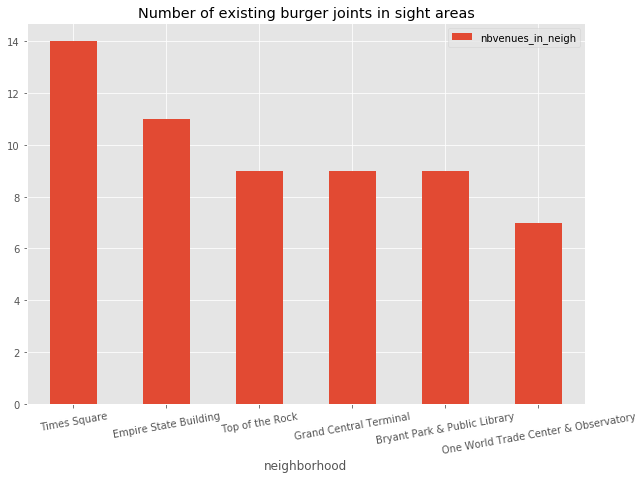

In [222]:
# Create a bar plot with number of burger joints for top 6 sightseeing spots

temp=df_sights.loc[:,['neighborhood','nbvenues_in_neigh']].sort_values(by='nbvenues_in_neigh',ascending=False).head(6)
#temp=df_sights.loc[:,['neighborhood','nbvenues_in_neigh']].sort_values(by='nbvenues_in_neigh',ascending=False)
temp.index=temp['neighborhood']
temp=temp.drop(columns=['neighborhood'], axis=1)
temp.plot.bar(figsize=(10,7))

plt.xticks(rotation=10)

plt.title('Number of existing burger joints in sight areas') 
#plt.savefig('NBVenuesperneigh.png')


In [225]:
# keep only burger joints within top 6 sight areas in the new dataframe
only_burger_neighsubset=only_burger[only_burger['neigh.id'].isin(lneighfinal)]
only_burger_neighsubset.shape

(59, 14)

#### 2.2 Get venue details of burger joints with Foursquare


We will now use the Foursquare API to extract the **rating for each competitor**.

Since we have checked above that duplicate venues exist belonging to more than one attraction, we will define a list of unique venues and call the API for these only:


In [226]:
lvenues=only_burger_neighsubset['venue.id'].unique().tolist()

print(lvenues)


['5723922f498efa17d6ffb135', '534330a7498e89554e17da87', '5ab5be3ad3cce81a8231ceb3', '5b417e4b4f0e58002cc97ee3', '5d27c8d9e0332c0023fd9910', '4f7b2878e4b0d7b576c06ea2', '586c34c965e7c738e8d105b4', '510ea2a5e4b0faae3c7d29aa', '5aecfc54491be7002c308012', '4e4c3cbabd413c4cc667de4e', '3fd66200f964a520c7e31ee3', '4c20ecac4889a59372262720', '4c88ea117223b1f7253e2fa8', '49e75ebff964a52090641fe3', '52b4ee02498edba6bb1c6d28', '4fde3ef6e4b09d5418211ca8', '4b0dc59af964a520cd4f23e3', '4bbe12bd8a4fb713bdcd3d9d', '53a877e9498e746b7aff3eff', '4d5eac5a149637044810cd94', '4c2bccc7d1a10f475a88f864', '596ea52ec9a51775f8ac079d', '4ce6d20af08f8eece5b40130', '4fe8877fe4b0227be1256499', '4a43b04ff964a520afa61fe3', '49c9358af964a52040581fe3', '4d5eb4429f67f04d1bcf63fb', '4eb2ec5077c846fcfeb2d366', '4ec151b4f79074116174939b', '5a341d6f2c7eb95c9bf6545c', '55689ffb498e6c30a2970838', '49dceeecf964a520c05f1fe3', '51ca35d4498e950b67e87df8', '5460fb3b498e94400cc7fd29', '4b44c9b4f964a52030fc25e3', '5702afe6498ec2255b

Also, we need to verify that we have not more than 50 venues in our list, as our Developer account limits the number of premium API calls to 50 per day.

In [227]:
nbvenues=len(only_burger_neighsubset['venue.id'].unique().tolist())
print(nbvenues)

48


We define a function that extracts the data from Foursquare for one venue id and yields a dataframe:

In [228]:
def get_venue_details(venue_id, CLIENT_ID, CLIENT_SECRET):
    
    version= '20180605'
    
    url='https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,  
        CLIENT_ID, 
        CLIENT_SECRET,
        version)

    try:
        results = requests.get(url).json()['response']
        
        venue_details = json_normalize(results) # json normalize tips

        filtered_columns = ['venue.id', 'venue.name','venue.stats.tipCount',
                            'venue.likes.count', 'venue.rating','venue.price.tier',
                            'venue.price.message','venue.description','venue.url',
                            'venue.bestPhoto.prefix','venue.bestPhoto.suffix']
                    
        
        
        venue_details =venue_details.loc[:, filtered_columns]
        
        
    except:
        
        None
        

    return venue_details 


Now we can run through all venues in our dataframe and call the function and concatenate everything into a single dataframe "venue_details":

In [229]:
venue_details = pd.DataFrame()

for venueid in lvenues:
    #print(venueid)
    temp= get_venue_details(venueid, CLIENT_ID, CLIENT_SECRET)
    venue_details=venue_details.append(temp)
    

In [230]:
venue_details

,venue.id,venue.name,venue.stats.tipCount,venue.likes.count,venue.rating,venue.price.tier,venue.price.message,venue.description,venue.url,venue.bestPhoto.prefix,...,venue.parent.location.labeledLatLngs,venue.parent.location.postalCode,venue.parent.location.cc,venue.parent.location.city,venue.parent.location.state,venue.parent.location.country,venue.parent.location.formattedAddress,venue.parent.categories,venue.parent.venuePage.id,venue.hierarchy
0,5723922f498efa17d6ffb135,Shake Shack,76,544,8.8,2.0,Moderate,Modern day version of a roadside burger stand ...,https://www.shakeshack.com,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,534330a7498e89554e17da87,Smashburger,55,168,7.5,1.0,Cheap,NaN,http://smashburger.com,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5ab5be3ad3cce81a8231ceb3,Five Guys,3,24,8.5,NaN,NaN,Five Guys is an award winning fast casual rest...,https://order.fiveguys.com/menu/five-guys-nyc-...,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5b417e4b4f0e58002cc97ee3,Holy Cow,3,8,6.7,NaN,NaN,NaN,NaN,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5d27c8d9e0332c0023fd9910,Black Tap,2,8,6.2,NaN,NaN,There are a lot of firsts at our newest NYC sp...,http://blacktap.com,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4f7b2878e4b0d7b576c06ea2,5 Boro Burger,32,59,5.7,2.0,Moderate,NaN,http://www.5boroburgernyc.com,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,586c34c965e7c738e8d105b4,Five Guys,4,2,5.8,1.0,Cheap,Five Guys is an award winning fast casual rest...,https://order.fiveguys.com/menu/five-guys-1802,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,510ea2a5e4b0faae3c7d29aa,BugerKing,0,0,NaN,NaN,NaN,NaN,NaN,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5aecfc54491be7002c308012,Ramen Burger by Kei Shimamoto,0,0,NaN,NaN,NaN,NaN,NaN,https://fastly.4sqi.net/img/general/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4e4c3cbabd413c4cc667de4e,American Burger & Co.,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we combine the rating info per burger joint with our old dataframe containing the existing burger joints near each attraction using the pandas merge function and joining by venue id:

In [231]:
only_burger_info= only_burger_neighsubset.merge(venue_details[['venue.id','venue.stats.tipCount',
                            'venue.likes.count', 'venue.rating','venue.price.tier',
                            'venue.price.message','venue.description','venue.url',
                            'venue.bestPhoto.prefix','venue.bestPhoto.suffix']],
                  on='venue.id',
                  how='left')

In [232]:
only_burger_info




,venue.name,venue.id,venue.distance,venue.category_name,venue.category_id,venue.address,venue.latlng,neighborhood,neigh.id,neigh.latlng,...,venue.xy,venue.stats.tipCount,venue.likes.count,venue.rating,venue.price.tier,venue.price.message,venue.description,venue.url,venue.bestPhoto.prefix,venue.bestPhoto.suffix
0,Shake Shack,5723922f498efa17d6ffb135,355,Burger Joint,4bf58dd8d48988d16c941735,"1333 Broadway (at W 36th St),New York, NY 10018","[40.75125311310451, -73.98762983461616]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2122890.622408391, -10791252.115413133]",76,544,8.8,2.0,Moderate,Modern day version of a roadside burger stand ...,https://www.shakeshack.com,https://fastly.4sqi.net/img/general/,/10638803_QcNFnm1hj8txGl0w5vb-I0C6afW4QbFoKYKx...
1,Smashburger,534330a7498e89554e17da87,30,Burger Joint,4bf58dd8d48988d16c941735,"10 W 33rd St (btwn 5th & 6th Aves),New York, N...","[40.748158600458474, -73.98560391189687]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2123143.291373077, -10791268.8427133]",55,168,7.5,1.0,Cheap,NaN,http://smashburger.com,https://fastly.4sqi.net/img/general/,/16746140_llS6tviV_AaFgBeE6f2c0Ye-Cs1crLY2WzyJ...
2,Five Guys,5ab5be3ad3cce81a8231ceb3,384,Burger Joint,4bf58dd8d48988d16c941735,"1008 Avenue of the Americas (W 38th),New York,...","[40.75186898405478, -73.98599395904462]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2123050.237283933, -10791354.11945306]",3,24,8.5,NaN,NaN,Five Guys is an award winning fast casual rest...,https://order.fiveguys.com/menu/five-guys-nyc-...,https://fastly.4sqi.net/img/general/,/5712424_yGydZk0Mohd-CEbX7NvDCN3SJE82XyLl8ExIu...
3,Holy Cow,5b417e4b4f0e58002cc97ee3,352,Burger Joint,4bf58dd8d48988d16c941735,"15 W 29th St (btwn Broadway & 5th Ave),New Yor...","[40.74581062237482, -73.98801136446032]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2122928.9305996867, -10791077.786127763]",3,8,6.7,NaN,NaN,NaN,NaN,https://fastly.4sqi.net/img/general/,/542744165_Yu54KAcSYvMhjHovUvwOFJsLOjMvT6JdkPX...
4,Black Tap,5d27c8d9e0332c0023fd9910,198,Burger Joint,4bf58dd8d48988d16c941735,"45 W 35th St (btwn 5th & 6th Ave),New York, NY...","[40.75019684647463, -73.98597798895493]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2123075.7229387844, -10791307.43419566]",2,8,6.2,NaN,NaN,There are a lot of firsts at our newest NYC sp...,http://blacktap.com,https://fastly.4sqi.net/img/general/,/30750238_WMRY41J-gQqtk05WpTvYoHLSbcqjBetERt-d...
5,5 Boro Burger,4f7b2878e4b0d7b576c06ea2,300,Burger Joint,4bf58dd8d48988d16c941735,"80 W 36th St (6th Ave),New York, NY 10018","[40.750989864537374, -73.9867813318502]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2122981.7200400755, -10791288.467665775]",32,59,5.7,2.0,Moderate,NaN,http://www.5boroburgernyc.com,https://fastly.4sqi.net/img/general/,/420398_IIaRzkXFJC_jz_2Tng0XxtFvyalqdhz_puRn5T...
6,Five Guys,586c34c965e7c738e8d105b4,248,Burger Joint,4bf58dd8d48988d16c941735,"148 Madison Ave,New York, NY 10016","[40.746466, -73.984262]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2123305.5651389435, -10791290.057586621]",4,2,5.8,1.0,Cheap,Five Guys is an award winning fast casual rest...,https://order.fiveguys.com/menu/five-guys-1802,https://fastly.4sqi.net/img/general/,/351960359_0p5qU-nN2mOt2-ow0SWPE5pyKrX_B8R71bB...
7,BugerKing,510ea2a5e4b0faae3c7d29aa,106,Burger Joint,4bf58dd8d48988d16c941735,"New York, NY 10001,United States","[40.747520446777344, -73.98527526855469]",Empire State Building,0,"[40.748428399999995, -73.98565461987332]",...,"[2123186.2212507967, -10791267.684841264]",0,0,NaN,NaN,NaN,NaN,NaN,https://fastly.4sqi.net/img/general/,/747461_G-dwK1Q1qOvH4rvqBMsybWs2lGFjwfi7joaQpp...
8,Ramen Burger by Kei Shimamoto,5aecfc54491be7002c308012,227,Burger Joint,4bf58dd8d48988d16c941735,"New York, NY 10001,United States","[40.749136, -73.988186]",Empire State 

In [233]:

only_burger_info['neighborhood'] =[neigh.split(",") [0] for neigh in only_burger_info['neighborhood']]


#save as csv
only_burger_info.to_csv('only_burger_info.csv')

In [116]:
#only_burger_info=pd.read_csv('only_burger_info.csv')  

We notice that for some venues in our list no rating information is available (NAN). However, we decide not to drop these rows at the moment.

### 3. Construction of Weights

Based on the venues' ratings we are now able to construct a weight for each burger joint in each sightseeing attraction group.

We simply divide a venue's rating by the sum of ratings of all burger joints near the attraction. 

Therefore, burgers joint with a higher rating will receive a higher weight in the optimization problem, i.e. the higher the rating of a competitor the farer away we will try to place the new burger business from the existing burger joint; yet under the constraint that the location of our new business is still in the circular area around the attraction.

In [234]:

only_burger_info['sum_rating_neigh'] = only_burger_info['venue.rating'].groupby(only_burger_info['neigh.id']).transform('sum')
only_burger_info['weights']=only_burger_info['venue.rating']/only_burger_info['sum_rating_neigh']

Let us also define equal weights as well. We can later repeat our analysis with these weights to see what happens if we don't take into account ratings when maximizing the distance to existing competitors. 

In [235]:
only_burger_info['equalweights']=1/(only_burger_info['venue.id'].groupby(only_burger_info['neigh.id']).transform('count'))



In [236]:
# check that weights sum up to 100
only_burger_info.groupby('neigh.id')['weights'].sum()
#only_burger_info.groupby('neigh.id')['equalweights'].sum()


neigh.id
0     1.0
1     1.0
3     1.0
8     1.0
11    1.0
14    1.0
Name: weights, dtype: float64

## Methodology <a name="methodology"></a>

### 1. Data Exploration 

Let's perform some basic explanatory data analysis and derive some insights from our raw data. 



#### 1.1. Competitor Ratings

First let's analyse the **average rating of competitors near each attraction**:

In [237]:
neigh_rat_mean=only_burger_info.groupby(['neigh.id','neighborhood'])['venue.rating'].mean().to_frame(name ='avg_venue_rating').reset_index()
neigh_rat_mean[['neigh.id','neighborhood','avg_venue_rating']].sort_values(by='avg_venue_rating',ascending=False)


,neigh.id,neighborhood,avg_venue_rating
5,14,Bryant Park & Public Library,7.514286
2,3,Times Square,7.358333
4,11,One World Trade Center & Observatory,7.283333
1,1,Top of the Rock,7.200000
0,0,Empire State Building,7.028571
3,8,Grand Central Terminal,6.900000


Average ratings seem to be **fairly close**, although burger joints are **highest rated near Byrant Park & Public Library** with **7.5.**

In [238]:

#store average rating in the dataframe with the information on sightseeing locations
df_sights_top= df_sights_top.merge(neigh_rat_mean[['neigh.id', 'avg_venue_rating']],
                  on='neigh.id',
                  how='left')


In [239]:
df_sights_top

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh,avg_venue_rating
0,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0,7.358333
1,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0,7.028571
2,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0,7.200000
3,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0,6.900000
4,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0,7.514286
5,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0,7.283333


Let  us dig a little bit deeper and find out how the **distribution of competitor ratings** looks like near each sightseeing location. for this, we will use `box plots` which show the distribution of the data through five main dimensions: 

- **Minimun:** Smallest number in the dataset.
- **First quartile:** Middle number between the `minimum` and the `median`.
- **Second quartile (Median):** Middle number of the (sorted) dataset.
- **Third quartile:** Middle number between `median` and `maximum`.
- **Maximum:** Highest number in the dataset.

In [240]:
only_burger_info[only_burger_info['neigh.id']==0].loc[:,'venue.rating']

0     8.8
1     7.5
2     8.5
3     6.7
4     6.2
5     5.7
6     5.8
7     NaN
8     NaN
9     NaN
10    NaN
Name: venue.rating, dtype: float64

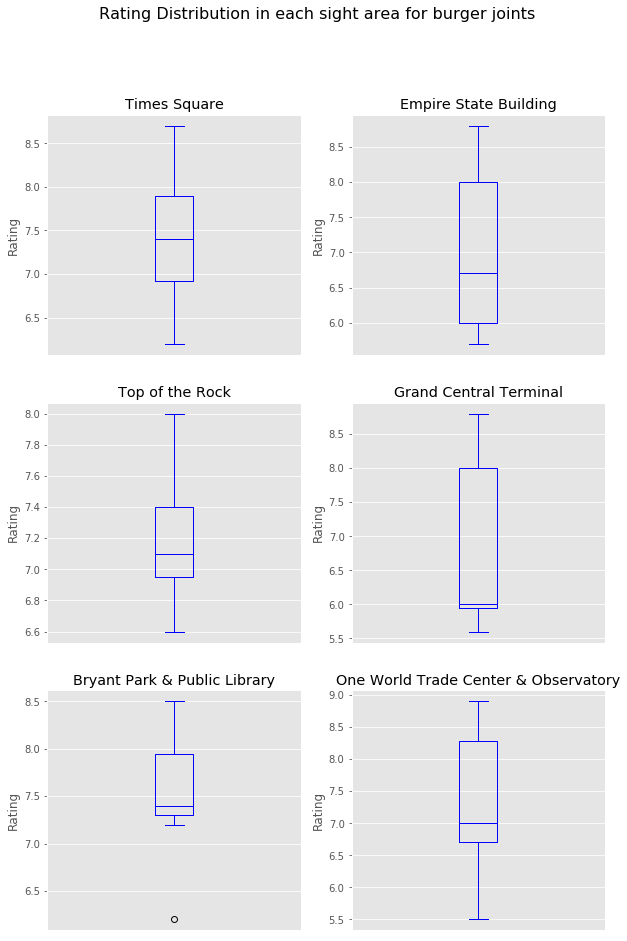

In [241]:
fig = plt.figure() 

fig.suptitle('Rating Distribution in each sight area for burger joints', fontsize=16) 

i=0
for n, name in zip(lneighfinal,lneighnamesfinal):
    #print(i,n)
    
    i=i+1
    temp=only_burger_info[only_burger_info['neigh.id']==n].loc[:,'venue.rating']
    #temp=temp.to_frame(name=name)
    
    ax0 = fig.add_subplot(3, 2, i) # add subplot 1 (3 row, 2 columns, first plot)
    
    temp.plot(kind='box', color='blue', figsize=(10, 15), ax=ax0) # add to subplot 1
    
    ax0.set_title(name)
    ax0.get_xaxis().set_visible(False)

    #ax0.set_xlabel('neighborhood')
    ax0.set_ylabel('Rating')

   
#plt.show()

plt.savefig('BoxplotsRatings1.png')


We see a negative outlier near Bryant Park. Let us find out which burger joint has such a bad rating there:

In [242]:
temp=only_burger_info[only_burger_info['neigh.id']==14]
temp.loc[temp['venue.rating'].idxmin(),['venue.name','venue.id','neighborhood','venue.rating']]      
   

venue.name                         HB Burger
venue.id            49dceeecf964a520c05f1fe3
neighborhood    Bryant Park & Public Library
venue.rating                             6.2
Name: 56, dtype: object

#### 1.2. Distances of Competitors from sightseeing attraction

Secondly, let's analyse the **distances of competitors from the mapped attraction**:


In [885]:
only_burger_info.dtypes

venue.name                 object
venue.id                   object
venue.distance             object
venue.category_name        object
venue.category_id          object
venue.address              object
venue.latlng               object
neighborhood               object
neigh.id                   object
neigh.latlng               object
address                    object
venue.dist_GEOD           float64
venue.dist_Haversine      float64
venue.xy                   object
venue.stats.tipCount        int64
venue.likes.count           int64
venue.rating              float64
venue.price.tier          float64
venue.price.message        object
venue.description          object
venue.url                  object
venue.bestPhoto.prefix     object
venue.bestPhoto.suffix     object
sum_rating_neigh          float64
weights                   float64
equalweights              float64
dtype: object

In [243]:
only_burger_info['venue.distance'] = only_burger_info['venue.distance'].astype('float64')


                               
                               

In [244]:
venue_dist_mean=only_burger_info.groupby(['neigh.id','neighborhood'])['venue.distance'].mean().to_frame(name ='avg_venue_dist').reset_index()
venue_dist_mean[['neigh.id','neighborhood','avg_venue_dist']].sort_values(by='avg_venue_dist',ascending=False)


,neigh.id,neighborhood,avg_venue_dist
5,14,Bryant Park & Public Library,335.888889
4,11,One World Trade Center & Observatory,310.142857
0,0,Empire State Building,254.181818
2,3,Times Square,245.785714
1,1,Top of the Rock,226.666667
3,8,Grand Central Terminal,213.111111


We see that burger joints are (expectedly) nearest to Grand Central Terminal whereas the average distance to the attraction is larger in the Bryant Park and On World Trade Center cluster.

In [245]:
df_sights_top= df_sights_top.merge(venue_dist_mean[['neigh.id', 'avg_venue_dist']],
                  on='neigh.id',
                  how='left')


df_sights_top

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh,avg_venue_rating,avg_venue_dist
0,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0,7.358333,245.785714
1,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0,7.028571,254.181818
2,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0,7.200000,226.666667
3,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0,6.900000,213.111111
4,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0,7.514286,335.888889
5,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0,7.283333,310.142857


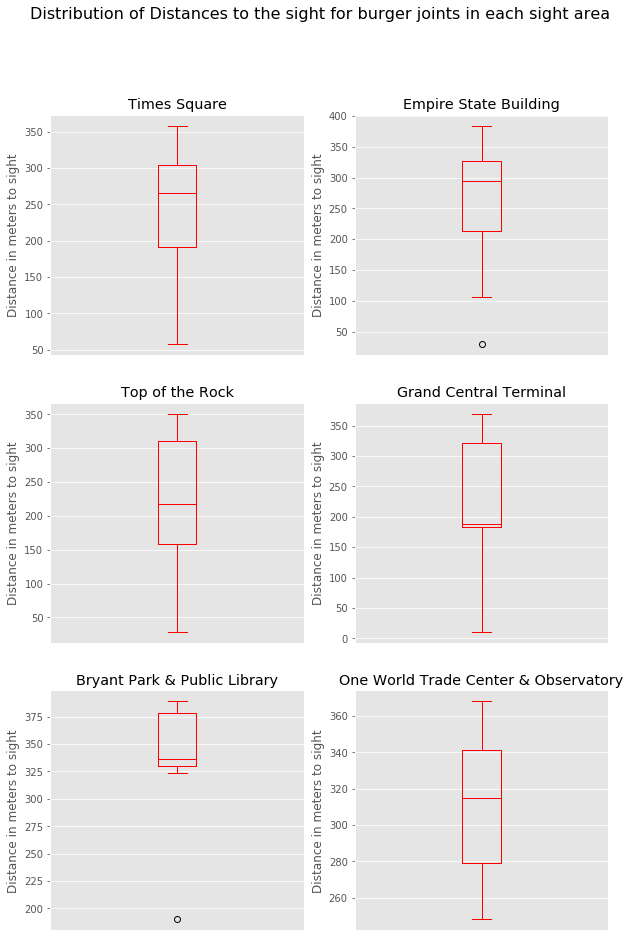

In [246]:
fig = plt.figure() 

fig.suptitle('Distribution of Distances to the sight for burger joints in each sight area', fontsize=16) 

i=0
for n, name in zip(lneighfinal,lneighnamesfinal):
    #print(i,n)
    
    i=i+1
    temp=only_burger_info[only_burger_info['neigh.id']==n].loc[:,'venue.distance']
    temp=temp.to_frame(name=name)
    
    ax0 = fig.add_subplot(3, 2, i) # add subplot 1 (3 row, 2 columns, first plot)
    
    temp.plot(kind='box', color='red', figsize=(10, 15), ax=ax0) # add to subplot 1
    
 
    ax0.set_title(name)
    ax0.get_xaxis().set_visible(False)
    
    ax0.set_ylabel('Distance in meters to sight')


  
plt.show()

fig.savefig('BoxplotsDistances.png')


Compared to other restaurants near the respective sightseeing attraction we can see that near Empire State Building and Bryant Park, the following restaurants have the most advantageous position (i.e. by far the nearest location to the attraction):

In [248]:
temp=only_burger_info[only_burger_info['neigh.id']==0]
temp.loc[temp['venue.distance'].idxmin(),['venue.name','venue.id','neighborhood','venue.distance','venue.rating']] 

venue.name                     Smashburger
venue.id          534330a7498e89554e17da87
neighborhood         Empire State Building
venue.distance                          30
venue.rating                           7.5
Name: 1, dtype: object

In [249]:
temp=only_burger_info[only_burger_info['neigh.id']==14]
temp.loc[temp['venue.distance'].idxmin(),['venue.name','venue.id','neighborhood','venue.distance','venue.rating']] 

venue.name                         STK Midtown
venue.id              4eb2ec5077c846fcfeb2d366
neighborhood      Bryant Park & Public Library
venue.distance                             190
venue.rating                               7.2
Name: 53, dtype: object

Is there a relationship betwenn the distance to the sightseeing attraction and ratings of burger joints?

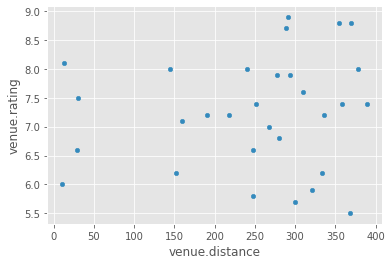

In [251]:


temp=only_burger_info.dropna(subset=['venue.rating','venue.distance','venue.price.tier'])

temp =temp.loc[:,['neighborhood','venue.rating','venue.distance','venue.price.tier']]

ax1= temp.plot.scatter(x='venue.distance',
                      y='venue.rating')

plt.savefig('linregratingdist.png')





There seems slight positive relationship between the distance to the main attraction and the rating of burger joints. 

Let's check if we can confirm this positive linear relationship by linear regression analysis:



In [252]:

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

X = temp[['venue.distance']]
y = temp[['venue.rating']]

model = LinearRegression()

model.fit(X,y)

r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficient:', model.coef_)


X2=sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

coefficient of determination: 0.016642313931501507
intercept: [6.96837942]
coefficient: [[0.00112047]]
                            OLS Regression Results                            
Dep. Variable:           venue.rating   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.4739
Date:                Mon, 29 Jun 2020   Prob (F-statistic):              0.497
Time:                        21:33:00   Log-Likelihood:                -40.976
No. Observations:                  30   AIC:                             85.95
Df Residuals:                      28   BIC:                             88.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------

According  to the coefficient of determination however, only 1.6 % of the variance in ratings can be explained by the variance of the venue distances. We cannot reject the null hypothesis that the slope coefficient of the venue distance is null in the regression according to the t-statistic and p value. Therefore we do not find a significant poitive linear relationship between distance to the sight and ratings.

#### 1.3. Price Range of Competitors

When we initially defined the business problem we did in fact make a **simplifying assumption**:

Potential customers *only* care about the walking **distance** to the burger joint and the **rating** of burger joints when they choose among burger joints yielded by the Foursquare API search.

Obviously, in reality customers are not only sensitive to quality but also to **price**.

Therefore, let us check how many venues are in each price category per neighborhood.

In [893]:
# create a dataframe with the sightseeing attractions, and dummy columns for each different price category
temp=only_burger_info.loc[:,['neighborhood','venue.price.message']]
temp = pd.get_dummies(temp, columns=['venue.price.message'],prefix="", prefix_sep="")

# Sum by rows to get the number of venues in each price category near each sightseeing location
temp = temp.groupby('neighborhood').sum().reset_index()
temp.index=temp['neighborhood']
temp=temp.drop(columns=['neighborhood'], axis=1)
temp


,Cheap,Expensive,Moderate,Very Expensive
neighborhood,,,,
Bryant Park & Public Library,0,1,2,1
Empire State Building,2,0,2,0
Grand Central Terminal,1,0,5,0
One World Trade Center & Observatory,0,0,4,0
Times Square,0,1,5,1
Top of the Rock,0,1,5,0


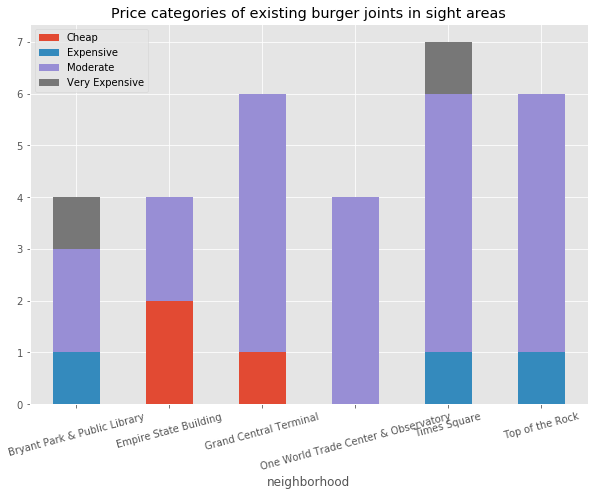

In [894]:
# Now we can easily  create a stacked bar plot
temp.plot.bar(stacked=True, figsize=(10,7))

plt.title ('Price categories of existing burger joints in sight areas')

#plt.get_xaxis().set_visible(False)
    
plt.xticks(rotation=15)
plt.savefig('StackedBarPriceRange.png')




We find the following:

* **Cheap burger joints** are mainly located near **Empire State Building** and **Grand Central Park** (in relative and absolute terms)
* The only attractions with **very expensive burger joints** are **Bryant Park** and **Times Squares**


We recall from the *Rating* section of the explanatory data analysis that the average rating of burger joints near Bryant Park and Times Squares was also the highest. So there could in fact be a positive correlation between the quality of a restaurant and price!

If the new burger joints beats its competitors in terms of price it might still win a customer over higher rated burger joints in Bryant Park and Times Squares, even if it opens next door to these.

### 2. Optimizer

Now it is time to create two Optimizer classes for:
* the Weiszfeld optimization method in order to find the worst location for a new business in each sight area
* A Primal-dual Inter Point Newton Method to find the best location for a new business in each sight area

#### 2.1 Worst Location

In [319]:
class OptiWeiszfeld(object):
    
    def __init__(self,mypoints,lweights,center,radius):
    
    
        self.mypoints= mypoints
        
        
        
        self.N=len(mypoints)
        self.weights =lweights 
        
        self.neighcenter=center
        self.neighradius=radius 
        
        self.epsilon=0.0001
        
   
        #self.max_iter=100

 
        
        
    def distance(self,point1, point2):
  
        distance =np.sqrt((point1[0]-point2[0])**2 +(point1[1]-point2[1])**2)
        return  distance
            
    def rminusdcenter(self,point):
        
        return self.neighradius-self.distance(point,  self.neighcenter)
        
        

    def check_constraint(self,point):
        
        return self.rminusdcenter(point) >=0
    
    
    
    def schwerpunkt(self):
        x0=y0=0
        n = len(self.mypoints)
        
        for P,w in zip(self.mypoints, self.weights):
            x0=x0+w*P[0]
            y0=y0+w*P[1]
            
        return [x0/n,y0/n]
    
    
    
    
    
    def get_Weiszfeld_approx(self,P):
        """
        Return a new approximation to the geometric median 
        of `points` by applying one iteration of Weiszfeld's 
        algorithm to the old appromixation P.
        """
        W = x = y = 0.0
      

        for Q, weight in zip(self.mypoints, self.weights):
            
            d = self.distance(P, Q)
            
            if d != 0:
       
            #minimize
               
                w= (weight/d) 
                W += w
                
                x += Q[0] * w
                y += Q[1] * w
                

    
        Weiszfeld_approx=[x/W,y/W]

        return Weiszfeld_approx
    
    

    def Weiszfeld_optimizer(self):
        """
        Return an approximation to the geometric median for 
        `points`. Start with the centroid and apply Weiszfeld's 
        algorithm until the distance between steps is less 
        than `epsilon`.
        """
        n = len(self.mypoints)

        #P = list[sum(P[i] for P in self.mypoints) / n for i in range(n-1)]
        P=self.schwerpunkt()
    
        counter=0

        while True:

            Q = self.get_Weiszfeld_approx(P)
            counter=counter+1
            
    
            if self.distance(P, Q) < self.epsilon: 
        
        #or counter>self.max_iter :
                
                return Q
                
            
            P=Q
            

We first test the Weiszfeld Optimizer for a random set of 3 points.

In [320]:
xcoords= [np.random.uniform(-1, 1) for i in range(3)]
ycoords =[np.random.uniform(-1, 1) for i in range(3)]
mypoints=[[x, y] for x, y in zip(xcoords, ycoords)]

lweights=[0.2,0.3,0.5]
center=[0,0]
radius=3

#print(mypoints)
#print(center)

opti= OptiWeiszfeld(mypoints=mypoints,lweights=lweights,center=center,radius=radius)

print(opti.mypoints)
print(opti.schwerpunkt())

weiszapprox=opti.Weiszfeld_optimizer()

print(weiszapprox)

# This checks if the minimum lies within the circle area defined by the radius around the center point!
print(opti.check_constraint(weiszapprox))




[[0.07828523909804219, -0.900887004946721], [-0.7891762607741493, -0.6672884209627847], [-0.34364544548487896, -0.7746135472721587]]
[-0.13097285105169196, -0.25589023363808633]
[-0.34365910988056814, -0.7746117820033674]
True


Let us define the optimizer to find the best location, i.e. the point that maximizes weighted distances under the constraint that the distance from the center point (the sight) is not greater than some number

In [344]:
import numpy as np

class OptiLagrange(object):
    
    def __init__(self,mypoints,lweights,center,radius,maxit=500):
    

        self.mypoints= mypoints
        
        self.N=len(mypoints)
        self.weights =lweights 

        self.neighcenter=center 
    
        self.radius=radius
        

        self.max_iter=maxit 
        
        
        self.alpha=0.1
        #10 **-32
        
        self.epsilon=0.0001
        

        self.slack=10
        self.slack_bound=0.5
         
 
        self.mu=2
        
        
    
    def distance(self,point1, point2):
  
        distance =np.sqrt((point1[0]-point2[0])**2 +(point1[1]-point2[1])**2)
        return distance
            
        
        
    def rminusdcenter(self,point):
         return self.radius-self.distance(point,  self.neighcenter)
        

    def check_constraint(self,point):
        return   self.rminusdcenter(point) >=0
    
        #constraint g>=0, so that point in neighborhood radius
        
        

    
    def FObjective(self,parameters):
        
        point=[parameters[0],parameters[1]]
        slack=parameters[2]
   

        Tot=0.0
        F=0.0
        for Q, w in zip(self.mypoints,self.weights):
            
            Tot=Tot+w*self.distance(point, Q) 
            
     
        F=Tot+ slack *self.rminusdcenter(point)
        
        #maximizing F to minimizing -F
        
        return -F 
    
    
 
      
    def Check_KKT(self,parameters):
        '''
        Karush-Kuhn-tucker
        '''

        point=[parameters[0],parameters[1]]

        #grad=self.gradient_tot(parameters)

        #grad.dot(grad) <=self.alpha and 
        if self.check_constraint(point) and parameters[2]>=0 \
           and (abs(self.rminusdcenter(point))<=self.epsilon or parameters[2]<=self.epsilon) :
                    
            return True
        
        else:
            
             return False
        
    def gradient(self,parameters):

        
        point=[parameters[0],parameters[1]]
        
        slack=parameters[2]
        
        ygradient= 0.0
        xgradient=0.0
        
        for Q, weight in zip(self.mypoints, self.weights):
            
            d = self.distance(point, Q)
            
            if d != 0:
                    w=weight/d #maximize
                    xgradient += (point[0]-Q[0])* w
                    ygradient += (point[1]-Q[1])* w
        
        dcenter=self.distance(point,self.neighcenter)
        center=self.neighcenter

        xgradient=-xgradient + (point[0]-center[0])/dcenter *slack 
        ygradient=-ygradient + (point[1]-center[1])/dcenter *slack 
        
        slackgradient=-self.rminusdcenter(point)
        
        gradient=[xgradient,ygradient,slackgradient] # -since minimizing

        return np.array(gradient)
        
    def Hessian (self,parameters):
        '''
        NEW
        '''
        point=[parameters[0],parameters[1]]
        
        slack=parameters[2]
      
        yy= 0.0
        xx=0.0
        xy=0.0
        
        
        for Q, weight in zip(self.mypoints, self.weights):
            d = self.distance(point, Q)
            if d != 0:
                    w=weight/d #maximize
                    xx += (1-pow((point[0]-Q[0])/d,2)) * w
                    yy += (1-pow((point[1]-Q[1])/d,2)) * w
                    
                    xy=-1.0*((point[0]-Q[0])*(point[1]-Q[1])*(1/d)*w)/d
        
        dcenter=self.distance(point,self.neighcenter)
        center=self.neighcenter
        
        x0=1-pow((point[0]-center[0])/dcenter,2)
        y0=1-pow((point[1]-center[1])/dcenter,2)
        
        xyc=(point[0]-center[0])*(point[1]-center[1]) *1/pow(dcenter,2)

        xx=-xx + slack* x0/dcenter  
        yy=-yy + slack* y0/dcenter 
        
        xy=-xy -slack * xyc/dcenter 
        
        
        xs=  (point[0]-center[0])/dcenter 
        ys=  (point[1]-center[1])/dcenter  
        
        ss=0

        Hessian= np.array([[xx, xy, xs],[xy,yy,ys],[xs,ys,ss]])
        
  

        return Hessian

    
    
        
        
    def get_Newton_approx2(self,parameters):
        """
        Return a new approximation of `points` by applying one iteration of Newton's 
        algorithm to the old appromixation P.
        """
        xold=np.array(parameters)
        
        grad=self.gradient(parameters)
        
        H=self.Hessian(parameters)
        Hinverse= np.linalg.inv(H) 
     
        
        xnew=xold-np.dot(Hinverse,grad)
        
   
        return xnew.tolist()




    def Newton_Find_activeset(self,parameters):
        """
        Returns the active set and updates slack param accordingly
        """

        slack_bound= self.slack_bound
        
        counterinner=0
     
   
        
        while  counterinner<self.max_iter:
            
            Q = self.get_Newton_approx2(parameters)
            
            counterinner=counterinner+1
            
            grad=self.gradient(parameters)
            
            point=[Q[0],Q[1]]
          
      
            if grad.dot(grad)<self.alpha   and self.check_constraint(point): #we found the active set

                    #now update slack for the active set and go out of loop
                    #restricted
                    
                    slacknew=Q[2]
                    slack=parameters[2]

                    if ((slacknew/slack)<=slack_bound):
                                slacknew=slack_bound

                       
                    if ((slacknew/slack)>=1/slack_bound):
                                slacknew=1/slack_bound


                    parameters=[Q[0],Q[1],slacknew]
                    break
                         
                    
          
            parameters=Q
        
 
        return parameters
        
            

        
    def Newton_optimizer2(self):

   
        initialguess=self.mypoints[0]
        
        parameters=[initialguess[0],initialguess[1],self.slack]
        
        counter=0
        
        while counter <self.max_iter :
            
            counter=counter+1
            
            
            fkminus1=self.FObjective(parameters)
            
            m=self.Newton_Find_activeset(parameters)
            
            fk=self.FObjective(m)
         
            stopcrit=abs(fk-fkminus1)/(1+abs(fk))
            
            if stopcrit<self.epsilon:
                    parameters=m
                    break
                 
             
            
            parameters=m
            
        return parameters
                    

We first test the Optimizers for a random set of points

In [345]:
xcoords= [round(np.random.uniform(0, 1),4) for i in range(3)]
ycoords =[round(np.random.uniform(0, 1),4) for i in range(3)]
mypoints=[[x, y] for x, y in zip(xcoords, ycoords)]

lweights=[0.2,0.3,0.5]
center=[0,0]

radiustest=3

print(mypoints)

[[0.7005, 0.1853], [0.9219, 0.2837], [0.6426, 0.2081]]


In [346]:
opti= OptiLagrange(mypoints=mypoints,lweights=lweights,center=center,radius=radiustest)


In [311]:
print(opti.alpha)

0.1


In [353]:
final=opti.Newton_optimizer2()
point=[final[0],final[1]]
slack=final[1]


print(final)

#print(opti.Check_KKT(final))


print(opti.check_constraint(point))


print(opti.rminusdcenter(point))

grad=opti.gradient(final)
print(opti.gradient(final))


#print(grad.dot(grad))



[-2.868201952290722, -0.8794416187989343, 0.9999921887282521]
True
0.0
[-1.08738574e-11  3.33405525e-12 -0.00000000e+00]


In [355]:
initialguess=mypoints[0]

parameters=[initialguess[0],initialguess[1],opti.slack]

counter=0

print(counter)
print(parameters)
print(opti.check_constraint(parameters))

while counter <opti.max_iter :
            
            counter=counter+1
            
            print(fkminus1)
            fkminus1=opti.FObjective(parameters)
            
            m=opti.Newton_Find_activeset(parameters)
            
            fk=opti.FObjective(m)
            
            print(counter)
            print('objective function')
            print(fk)
         
            stopcrit=abs(fk-fkminus1)/(1+abs(fk))
            
            if stopcrit<opti.epsilon:
                    parameters=m
                    print('optimum')
                    break
                 
             
            
            parameters=m
            
print(parameters)
                    
point=[parameters[0],parameters[1]]

print(opti.Check_KKT(parameters))

print(opti.check_constraint(point))

print(opti.rminusdcenter(point))

grad=opti.gradient(parameters)
print(opti.gradient(parameters))


0
[0.7005, 0.1853, 10]
True
-3.7718937508224837
1
objective function
-3.7718937508224837
-22.85785913476667
2
objective function
-3.771893750822483
optimum
[-2.868201952290722, -0.8794416187989343, 0.9999921887282521]
True
True
0.0
[-1.08738574e-11  3.33405525e-12 -0.00000000e+00]


Let's test the optimizer for one sight area.

Add 2D coordinates for sight to data frame only_burger_info:

In [270]:
only_burger_info['neigh.xy']=only_burger_info.apply(lambda x: LatLon_To_XY(x['neigh.latlng']), axis=1)

Compute the euclidean distance between sight and burger joints based on the coordinates that were mapped to the 2d Cartesian system:

In [299]:

#function
def get_distance_euclidean(xy1, xy2):
    
    '''
    Euclidean Distance in meters between two points in 2D system
    ''' 

    distance = np.sqrt((xy1[0]-xy2[0])**2 +(xy1[1]-xy2[1])**2)
    
    return distance

# add euclidean dist to df
only_burger_info['venue.dist_euclidean']=only_burger_info.apply(lambda x: get_distance_euclidean(x['venue.xy'],x['neigh.xy']), axis=1)

Define subset of venues in sight area 14 :

In [357]:

subset1=only_burger_info[only_burger_info['neigh.id']==14]

subset2=subset1.copy()
subset2=subset2.dropna(subset=['weights'])
    
lweights2=subset2['weights'].tolist()
mypoints2=subset2['venue.xy'].tolist() 


In [358]:

subset2[['venue.name','venue.distance','venue.dist_euclidean','venue.rating','weights','neigh.id','venue.xy','neigh.xy']]

,venue.name,venue.distance,venue.dist_euclidean,venue.rating,weights,neigh.id,venue.xy,neigh.xy
50,Burger & Lobster,336.0,258.837772,7.9,0.150190,14,"[2123094.398215129, -10791526.926593492]","[2123350.491318481, -10791564.520672439]"
51,The Counter,378.0,452.602575,8.0,0.152091,14,"[2122924.8436636925, -10791410.65981003]","[2123350.491318481, -10791564.520672439]"
52,Five Guys,324.0,366.634912,8.5,0.161597,14,"[2123050.237283933, -10791354.11945306]","[2123350.491318481, -10791564.520672439]"
53,STK Midtown,190.0,54.723512,7.2,0.136882,14,"[2123321.567852447, -10791610.975982692]","[2123350.491318481, -10791564.520672439]"
54,BV's Burger,387.0,156.074996,7.4,0.140684,14,"[2123201.3486556644, -10791610.519264465]","[2123350.491318481, -10791564.520672439]"
55,Ruby Tuesday,389.0,474.269618,7.4,0.140684,14,"[2122905.997256477, -10791399.122063762]","[2123350.491318481, -10791564.520672439]"
56,HB Burger,334.0,253.533325,6.2,0.117871,14,"[2123099.403793464, -10791529.38946779]","[2123350.491318481, -10791564.520672439]"


The problem is that the euclidean distance between the mapped xy coordinates of the sight/neighborhood and the mapped coordinates xy of a burger venue does not correspond to the real distance to the venue (field venue.distance). But this has an impact on the optimizer as we must define the radius for the inequality constraint! Not sure what the issue is here... However let's define the max. tolerated radius to the sight from the best location as the max. calculated euclidean distance over all venues to all attractions:

In [359]:
        
#max distance to attraction over all venues
temp=only_burger_info
temp.loc[temp['venue.dist_euclidean'].idxmax(),['venue.name','venue.id','neighborhood','venue.dist_euclidean','venue.distance','venue.xy']] 

radiusmaxdist=temp.loc[temp['venue.dist_euclidean'].idxmax(),'venue.dist_euclidean'] 

print('max. radius to sight')
print(radiusmaxdist)
center=subset2[['neigh.xy']].iloc[0,0]

print('coordinates sight')
print(center)
        
print('weights')
print(lweights2)

print('competitor coordinates')
print(mypoints2)


max. radius to sight
501.70843572959484
coordinates sight
[2123350.491318481, -10791564.520672439]
weights
[0.15019011406844107, 0.1520912547528517, 0.16159695817490494, 0.13688212927756654, 0.14068441064638784, 0.14068441064638784, 0.11787072243346007]
competitor coordinates
[[2123094.398215129, -10791526.926593492], [2122924.8436636925, -10791410.65981003], [2123050.237283933, -10791354.11945306], [2123321.567852447, -10791610.975982692], [2123201.3486556644, -10791610.519264465], [2122905.997256477, -10791399.122063762], [2123099.403793464, -10791529.38946779]]


In [327]:


opti= OptiLagrange(mypoints=mypoints2,lweights=lweights2,center=center,radius=radiusmaxdist)

In [328]:
final=opti.Newton_optimizer2()
print(final)

print(opti.Check_KKT(final))

point=[final[0],final[1]]
slack=final[1]

print(opti.check_constraint(point))


print(opti.rminusdcenter(point))

grad=opti.gradient(final)
print(opti.gradient(final))




[2120338.64791802, -10788679.94587637, 0.9843920015067178]
True
True
7.383960110018961e-11
[-5.51929070e-08 -1.99567582e-08 -7.38396011e-11]


## Results and Discussion <a name="results"></a>

Let us create a Dataframe to store the Optimization results:

In [317]:
results=df_sights_top

results.index=results['neigh.id']

#print(results.loc[3,'neigh.xy'])


lresultcolumns=['Newton.xy','IneqConstraint_Newton','Weiszfeld.xy','IneqConstraint_Weiszfeld',
                'Newtoneq.xy','IneqConstraint_Newtoneq','Weiszfeldeq.xy','IneqConstraint_Weiszfeldeq']
       
results = results.reindex(columns = results.columns.tolist() + lresultcolumns)
results['Newton.xy'] = results['Newton.xy'].astype(object)
results['Weiszfeld.xy'] = results['Weiszfeld.xy'].astype(object)

results['Newtoneq.xy'] = results['Newtoneq.xy'].astype(object)
results['Weiszfeldeq.xy'] = results['Weiszfeldeq.xy'].astype(object)


results

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh,avg_venue_rating,avg_venue_dist,Newton.xy,IneqConstraint_Newton,Weiszfeld.xy,IneqConstraint_Weiszfeld,Newtoneq.xy,IneqConstraint_Newtoneq,Weiszfeldeq.xy,IneqConstraint_Weiszfeldeq
neigh.id,,,,,,,,,,,,,,,,
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0,7.358333,245.785714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0,7.028571,254.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0,7.200000,226.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0,6.900000,213.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0,7.514286,335.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0,7.283333,310.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's find the worst location for each sight area:

In [321]:
radiusnormal= 400

for neighid in lneighfinal:
    #print(neighid)
 
    # for equal weights of competitors
    subset1=only_burger_info[only_burger_info['neigh.id']==neighid]
    lweights=subset1['equalweights'].tolist()
    mypoints=subset1['venue.xy'].tolist() 
    

    #print(lweights)
    #print(mypoints)
    
    #with rating based weights
    
    subset2=subset1.copy()
    subset2=subset2.dropna(subset=['weights'])
    
    lweights2=subset2['weights'].tolist()
    mypoints2=subset2['venue.xy'].tolist() 
    
    #print(lweights2)
    #print(mypoints2)
    
    center=results.loc[neighid,'neigh.xy'] 

    optiw_equal= OptiWeiszfeld(mypoints=mypoints,lweights=lweights,center=center,radius=radiusnormal)
    optiw= OptiWeiszfeld(mypoints=mypoints2,lweights=lweights2,center=center,radius=radiusnormal)
    


    xy_optiw_equal=optiw_equal.Weiszfeld_optimizer()
    InR_optiw_equal=optiw_equal.check_constraint(xy_optiw_equal)
    
    xy_optiw=optiw.Weiszfeld_optimizer()
    InR_optiw=optiw.check_constraint(xy_optiw)
    

        
    results.at[neighid,'Weiszfeld.xy']=xy_optiw
    results.loc[neighid,'IneqConstraint_Weiszfeld']=InR_optiw
    
    results.at[neighid,'Weiszfeldeq.xy']= xy_optiw_equal
    results.loc[neighid,'IneqConstraint_Weiszfeldeq']= InR_optiw_equal
    



We get the address and latitude/longitude degrees for the worst location returned by the optimizer

In [322]:

results['Weiszfeld.latlng']=results.apply(lambda x: XY_To_LatLon(x['Weiszfeld.xy']), axis=1)

results['Weiszfeld.address']=results.apply(lambda x: get_address_from_latlng(x['Weiszfeld.latlng']), axis=1)


In [902]:
results

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh,avg_venue_rating,avg_venue_dist,Newton.xy,IneqConstraint_Newton,Weiszfeld.xy,IneqConstraint_Weiszfeld,Newtoneq.xy,IneqConstraint_Newtoneq,Weiszfeldeq.xy,IneqConstraint_Weiszfeldeq,Weiszfeld.latlng,Weiszfeld.address
neigh.id,,,,,,,,,,,,,,,,,,
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0,7.358333,245.785714,NaN,NaN,"[2122906.411360351, -10791426.266351135]",True,NaN,NaN,"[2122963.0875312444, -10791486.007754078]",True,"[40.7559268937453, -73.98682906420301]",42nd Street–Times Square–Port Authority Bus Te...
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0,7.028571,254.181818,NaN,NaN,"[2123056.380439615, -10791297.40538292]",True,NaN,NaN,"[2123059.0473721167, -10791286.805905985]",True,"[40.75018777404518, -73.98616714480063]","51, West 35th Street, Midtown South, Manhattan..."
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0,7.200000,226.666667,NaN,NaN,"[2123582.699177336, -10791836.08660797]",True,NaN,NaN,"[2123482.4221860906, -10791828.825188056]",True,"[40.757904378705874, -73.97998499631247]","38, West 48th Street, Midtown, Manhattan, Manh..."
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0,6.900000,213.111111,NaN,NaN,"[2124006.444364212, -10791848.711735561]",True,NaN,NaN,"[2123993.0051461137, -10791886.667207258]",True,"[40.752282505055966, -73.97664771922678]","Grand Hyatt New York, 109, Park Avenue, Murray..."
14,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0,7.514286,335.888889,NaN,NaN,"[2123094.4037174424, -10791526.914787132]",True,NaN,NaN,"[2123099.680380841, -10791524.191274403]",True,"[40.756103692725276, -73.98497825137767]","Heartland Brewery, 127, West 43rd Street, Time..."
11,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0,7.283333,310.142857,NaN,NaN,"[2120660.8388878396, -10788833.129224515]",True,NaN,NaN,"[2120948.043566786, -10789009.260789944]",True,"[40.7146330430627, -74.01435119613832]","Goldman Sachs Tower, 200, West Street, Battery..."


Let us print out the returned address for the worst location

In [323]:
results.loc[:,['neighborhood','Weiszfeld.address']]

,neighborhood,Weiszfeld.address
neigh.id,,
3,Times Square,42nd Street–Times Square–Port Authority Bus Te...
0,Empire State Building,"51, West 35th Street, Midtown South, Manhattan..."
1,Top of the Rock,"38, West 48th Street, Midtown, Manhattan, Manh..."
8,Grand Central Terminal,"Grand Hyatt New York, 109, Park Avenue, Murray..."
14,Bryant Park & Public Library,"Heartland Brewery, 127, West 43rd Street, Time..."
11,One World Trade Center & Observatory,"Goldman Sachs Tower, 200, West Street, Battery..."


We add the worst location to the folium map

In [339]:
for latlng,cluster in zip(results['Weiszfeld.latlng'],results['neigh.id']):

    label = 'Worst location in sight area {}'.format(cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        latlng,
        radius=5,
        popup=label,
        color='white',#rainbow[cluster], 
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1,
        parse_html=False).add_to(map_newyork)      

map_newyork




In [340]:
map_newyork.save("mapsightsandvenuesandworstloc.html")

Let's find the best location for each sight area:

In [329]:
print(radiusmaxdist)





for neighid in lneighfinal:

 
    #with eual weights
    subset1=only_burger_info[only_burger_info['neigh.id']==neighid]
    lweights=subset1['equalweights'].tolist()
    mypoints=subset1['venue.xy'].tolist() 
    

    
    #with rating based weights
    
    subset2=subset1.copy()
    subset2=subset2.dropna(subset=['weights'])
    lweights2=subset2['weights'].tolist()
    mypoints2=subset2['venue.xy'].tolist() 
    
    #print(lweights2)
    #print(mypoints2)
    
    center=results.loc[neighid,'neigh.xy'] 



    # equal weights
    
    
    optin_equal= OptiLagrange(mypoints=mypoints,lweights=lweights,center=center,radius=radiusmaxdist)
    
    tempeq=optin_equal.Newton_optimizer2()
    xy_optin_equal=[tempeq[0],tempeq[1]]
    
    InR_optin_equal=optin_equal.check_constraint(xy_optin_equal)
    
    
    # normal weights
    optin= OptiLagrange(mypoints=mypoints2,lweights=lweights2,center=center,radius=radiusmaxdist)
    
    
    
    temp=optin.Newton_optimizer2()
    xy_optin=[temp[0],temp[1]]
    
        
    print(optin.Check_KKT(temp))
    print(optin.rminusdcenter(xy_optin))
    grad=optin.gradient(temp)
    print(optin.gradient(temp))



    
    InR_optin=optin.check_constraint(xy_optin)
    
    

  
    results.at[neighid,'Newton.xy']=xy_optin
    results.loc[neighid,'IneqConstraint_Newton']=InR_optin
      
    results.at[neighid,'Newtoneq.xy']=xy_optin_equal
    results.loc[neighid,'IneqConstraint_Newtoneq']=InR_optin_equal
    
  

    
 


501.70843572959484
True
2.2737367544323206e-13
[ 3.41273546e-08  6.72207827e-08 -2.27373675e-13]
True
2.928004505520221e-10
[ 6.22657481e-12  1.24247834e-12 -2.92800451e-10]
True
2.368096829741262e-10
[-2.02173260e-07 -9.61580296e-08 -2.36809683e-10]
True
2.973479240608867e-10
[-5.17095300e-09 -1.00811634e-09 -2.97347924e-10]
True
1.5120349416974932e-11
[ 9.48591961e-09  2.34391057e-09 -1.51203494e-11]
True
7.383960110018961e-11
[-5.51929070e-08 -1.99567582e-08 -7.38396011e-11]


In [330]:
results['Newton.latlng']=results.apply(lambda x: XY_To_LatLon(x['Newton.xy']), axis=1)

results['Newton.address']=results.apply(lambda x: get_address_from_latlng(x['Newton.latlng']), axis=1)


In [331]:
results

,neighborhood,neigh.latlng,address,neigh.id,neigh.xy,nbvenues_in_neigh,avg_venue_rating,avg_venue_dist,Newton.xy,IneqConstraint_Newton,Weiszfeld.xy,IneqConstraint_Weiszfeld,Newtoneq.xy,IneqConstraint_Newtoneq,Weiszfeldeq.xy,IneqConstraint_Weiszfeldeq,Weiszfeld.latlng,Weiszfeld.address,Newton.latlng,Newton.address
neigh.id,,,,,,,,,,,,,,,,,,,,
3,Times Square,"[40.757280550000004, -73.98585503545917]","Times Square, Manhattan, Manhattan Community B...",3,"[2122987.368423276, -10791515.050357765]",14.0,7.358333,245.785714,"[2123214.4865963734, -10791962.407809844]",True,"[2122906.411360351, -10791426.266351135]",True,"[2122921.088213068, -10792012.36141557]",True,"[2122963.0875312444, -10791486.007754078]",True,"[40.7559268937453, -73.98682906420301]",42nd Street–Times Square–Port Authority Bus Te...,"[40.766650101550255, -73.98234993117761]","3, Columbus Circle, Manhattan, Manhattan Commu..."
0,Empire State Building,"[40.748428399999995, -73.98565461987332]","Empire State Building, 350, 5th Avenue, Midtow...",0,"[2123134.224768975, -10791273.889660975]",11.0,7.028571,254.181818,"[2122639.3528237953, -10791191.348081416]",True,"[2123056.380439615, -10791297.40538292]",True,"[2122665.990783285, -10791093.700068804]",True,"[2123059.0473721167, -10791286.805905985]",True,"[40.75018777404518, -73.98616714480063]","51, West 35th Street, Midtown South, Manhattan...","[40.75309019226883, -73.98981639241879]","200, West 37th Street, Garment District, Manha..."
1,Top of the Rock,"[40.7590344, -73.9793952]","Rockefeller Center, 45, Rockefeller Plaza, Mid...",1,"[2123627.286342919, -10791898.681288268]",9.0,7.200000,226.666667,"[2124080.3590678, -10792114.172495632]",True,"[2123582.699177336, -10791836.08660797]",True,"[2124057.8518559923, -10792156.217098271]",True,"[2123482.4221860906, -10791828.825188056]",True,"[40.757904378705874, -73.97998499631247]","38, West 48th Street, Midtown, Manhattan, Manh...","[40.75869835266829, -73.97504024367952]","Look Building, 488, Madison Avenue, Midtown Ea..."
8,Grand Central Terminal,"[40.7528064, -73.9771792]","Grand Central Terminal, Vanderbilt Avenue, Mid...",8,"[2123944.258225699, -10791836.14705995]",9.0,6.900000,213.111111,"[2123451.817840423, -10791740.158407332]",True,"[2124006.444364212, -10791848.711735561]",True,"[2123475.2990365694, -10791657.853388123]",True,"[2123993.0051461137, -10791886.667207258]",True,"[40.752282505055966, -73.97664771922678]","Grand Hyatt New York, 109, Park Avenue, Murray...","[40.7570548442416, -73.98137423220652]","59, West 46th Street, Midtown, Manhattan, Manh..."
14,Bryant Park & Public Library,"[40.753547675, -73.98284458175789]","Midtown South, Manhattan, Manhattan Community ...",14,"[2123350.491318481, -10791564.520672439]",9.0,7.514286,335.888889,"[2123837.546997038, -10791684.887281045]",True,"[2123094.4037174424, -10791526.914787132]",True,"[2123841.8140774216, -10791666.075096415]",True,"[2123099.680380841, -10791524.191274403]",True,"[40.756103692725276, -73.98497825137767]","Heartland Brewery, 127, West 43rd Street, Time...","[40.750060833014196, -73.978596313003]","100, East 39th Street, Murray Hill, Manhattan,..."
11,One World Trade Center & Observatory,"[40.713012125, -74.0131218489912]","One World Trade Center, 285, Fulton Street, We...",11,"[2120810.4596799538, -10788850.547798349]",7.0,7.283333,310.142857,"[2120338.64791802, -10788679.94587637]",True,"[2120660.8388878396, -10788833.129224515]",True,"[2120334.7104389826, -10788691.255569419]",True,"[2120948.043566786, -10789009.260789944]",True,"[40.7146330430627, -74.01435119613832]","Goldman Sachs Tower, 200, West Street, Battery...","[40.71486449473385, -74.01744833487197]",Brookfield Place / Battery Park City Ferry Ter...


Let's print out the address for the best location:

In [356]:
results.loc[:,['neighborhood','Newton.address']]

,neighborhood,Newton.address
neigh.id,,
3,Times Square,"3, Columbus Circle, Manhattan, Manhattan Commu..."
0,Empire State Building,"200, West 37th Street, Garment District, Manha..."
1,Top of the Rock,"Look Building, 488, Madison Avenue, Midtown Ea..."
8,Grand Central Terminal,"59, West 46th Street, Midtown, Manhattan, Manh..."
14,Bryant Park & Public Library,"100, East 39th Street, Murray Hill, Manhattan,..."
11,One World Trade Center & Observatory,Brookfield Place / Battery Park City Ferry Ter...


We add the best location to the map:

In [342]:
for latlng,cluster in zip(results['Newton.latlng'],results['neigh.id']):

    label = 'Best location in neighborhood {}'.format(cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        latlng,
        radius=5,
        popup=label,
        color='green',#rainbow[cluster], 
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1,
        parse_html=False).add_to(map_newyork)      

map_newyork


In [343]:
 map_newyork.save("mapsightsandvenuesandbestandworst.html")

## Conclusion <a name="conclusion"></a>

We have rated the attractiveness of the different sight areas and found the worst and best location for a new burger joint near each sight.

**THANK YOU!**